# Autoencoder para reducción de ruido

El modelo es tomado de [GuitarsAI](https://github.com/GuitarsAI) https://www.youtube.com/watch?v=gVFCX-olr-M

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import librosa
from pydub import AudioSegment

In [2]:
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cuda


In [3]:
os.chdir("../Audios")
wd=os.getcwd()
wd_norm=os.listdir('Normal')
wd_sarc=os.listdir('Sarcasmo')

## Con audios en MP3

In [4]:
y, sr = librosa.load("Normal/Audio_1.mp3")
librosa.feature.melspectrogram(y=y, sr=sr)

/home/thejarmanitor/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


array([[1.4124211e-04, 6.4624433e-04, 2.0889274e-03, ..., 2.6005888e-03,
        8.9461613e-04, 6.6318811e-04],
       [2.1077051e-04, 8.7722071e-04, 2.4391920e-03, ..., 1.4399672e-03,
        7.1109447e-04, 1.7961246e-03],
       [2.7493734e-04, 6.7092339e-04, 9.4860344e-04, ..., 2.6280112e-03,
        1.3145995e-03, 1.8213964e-03],
       ...,
       [1.7611904e-09, 9.3290140e-07, 8.9800005e-06, ..., 2.6329703e-09,
        2.8371495e-08, 8.7693940e-07],
       [8.1298424e-10, 3.4993198e-07, 2.6490557e-06, ..., 2.6378217e-09,
        2.4373133e-08, 7.6044631e-07],
       [4.5773423e-11, 2.9024948e-08, 2.8090284e-07, ..., 1.6430658e-10,
        1.5182458e-08, 5.0437274e-07]], dtype=float32)

In [5]:
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

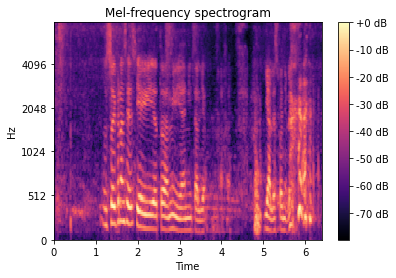

In [6]:
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [7]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [8]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        #Analysis:
        x = self.conv1(x)
        y = torch.tanh(x)
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        y=self.encoder(x)
        #y=torch.round(y/0.125)*0.125
        xrek=self.decoder(y)
        return xrek

In [9]:
batch=1
audio, samplerate = librosa.load("Normal/Audio_1.mp3", mono=False, sr=None, offset=6)
audio[0,:]/=np.abs(audio[0,:]).max()
audio[1,:]/=np.abs(audio[1,:]).max()
X_train=signal2pytorch(audio[0,:]).to(device) #Convert to pytorch format, batch is first dimension    
X_test=signal2pytorch(audio[1,:]).to(device) #Convert to pytorch format, batch is first dimension

/home/thejarmanitor/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [10]:
print("Generate Model:")
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Def. loss function:")
loss_fn = nn.MSELoss()  #MSE
#loss_fn = nn.L1Loss()
    
Ypred=model(X_train)
   
#Ypred=Ypred.detach()
outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X_train[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X_train.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
#print("max(max(Y))=", max(max(max(Y))))
#print("min(min(Y))=", min(min(min(Y))))
print("Y.type()=", Y.type())
print(Y.device)

Generate Model:
Total number of parameters: 131105
Def. loss function:
outputlen= 16386
Input X.shape= torch.Size([1, 1, 16488])
Target Y.shape= torch.Size([1, 1, 16386])
Target Y= tensor([[[-0.3389, -0.3659, -0.3847,  ...,  0.0043, -0.0045, -0.0097]]],
       device='cuda:0')
Y.type()= torch.cuda.FloatTensor
cuda:0


In [11]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
"""
try:
    checkpoint = torch.load("audio_autoenc.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except IOError:
    print("fresh start")
""";
    
#optimrandomdir_pytorch.optimizer(model, loss_fn, X, Ypred, iterations=300, startingscale=1.0, endscale=0.0)
Ypred=model(X_train)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)
    
#randdir=True # True for optimization of random direction, False for pytorch optimization
randdir=False
    
if randdir==True:
#optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X_train, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(4000):
        #distortions: shift and noise:
        #"""
        Xlast=X_train[:,:,-1].clone() 
        X_train[:,:,1:]=X_train[:,:,:-1].clone() #round Robbin, shift 1 right
        X_train[:,:,0]=Xlast.clone()
        Ylast=Y[:,:,-1].clone() 
        Y[:,:,1:]=Y[:,:,:-1].clone() #round Robbin, shift 1 right
        Y[:,:,0]=Ylast.clone()
        #"""
        Ypred=model(X_train+torch.randn(X_train.size()).to(device)*0.05)
        #print("Ypred.shape=", Ypred.shape)
        #loss wants batch in the beginning! (Batch, Classes,...)
        #Ypredp=Ypred.permute(1,2,0)
        #Yp=Y.permute(1,0)
        #print("Ypredp.shape=", Ypredp.shape, "Yp.shape=", Yp.shape )
        loss=loss_fn(Ypred, Y)
        if epoch%10==0:
            print(epoch, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Ypred= tensor([[[-0.0156, -0.0167, -0.0324,  ..., -0.0144, -0.0151, -0.0166]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
0 0.025022311136126518
10 0.02393895946443081
20 0.023068727925419807
30 0.02266131155192852
40 0.020382549613714218
50 0.016124609857797623
60 0.014878582209348679
70 0.015797985717654228
80 0.014651426114141941
90 0.011258972808718681
100 0.010280005633831024
110 0.01124891173094511
120 0.01106228120625019
130 0.009794989600777626
140 0.009022939018905163
150 0.009498133324086666
160 0.009435462765395641
170 0.009109562262892723
180 0.008578295819461346
190 0.008770639076828957
200 0.008671651594340801
210 0.008682980202138424
220 0.00828798022121191
230 0.008272266015410423
240 0.008402865380048752
250 0.008482537232339382
260 0.008351266384124756
270 0.008253181353211403
280 0.008137647993862629
290 0.008257226087152958
300 0.008226851932704449
310 0.008025183342397213
320 0.007958151400089264
330 0.008013224229216576
340 0.008165067993104458
350 0.007

ww= OrderedDict([('conv1.weight', tensor([[[-0.0024,  0.0037, -0.0215,  ..., -0.0117, -0.0492, -0.0312]],

        [[-0.0156, -0.0396, -0.0177,  ...,  0.0158,  0.0210, -0.0043]],

        [[ 0.0004,  0.0139,  0.0180,  ..., -0.0006,  0.0213,  0.0012]],

        ...,

        [[ 0.0034,  0.0027, -0.0017,  ...,  0.0259, -0.0011,  0.0127]],

        [[-0.0066,  0.0118, -0.0120,  ..., -0.0136, -0.0069, -0.0154]],

        [[ 0.0179,  0.0209, -0.0116,  ...,  0.0079,  0.0149,  0.0296]]])), ('conv1.bias', tensor([-5.6650e-03,  6.5698e-03, -1.8816e-04, -2.3886e-03, -2.3338e-03,
         6.3203e-03, -9.1823e-04,  4.1264e-03, -3.4485e-03, -1.9655e-03,
        -3.2938e-03,  1.0080e-02, -3.0815e-03,  5.7342e-03,  1.5575e-03,
        -7.5264e-06, -1.1753e-02, -3.7940e-03, -2.0288e-03, -9.9987e-03,
        -3.4776e-03,  4.7225e-03, -2.5171e-03,  1.1491e-02, -5.2775e-03,
        -1.4149e-03, -1.8471e-03,  7.4132e-03, -3.8254e-04,  1.1943e-03,
         5.2397e-03, -3.1103e-03])), ('synconv1.weight', te

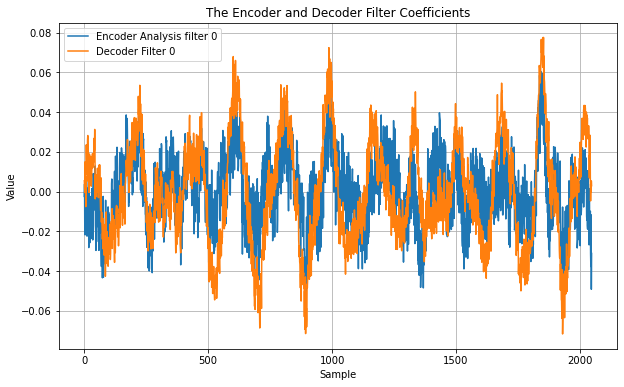

In [12]:
"""
torch.save({#'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, "audio_autoenc.torch")
"""
    
ww = model.cpu().state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,6))
plt.plot(np.transpose(np.array(ww['conv1.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

(1, 1, 16386)
predictions.shape= (1, 1, 16386)


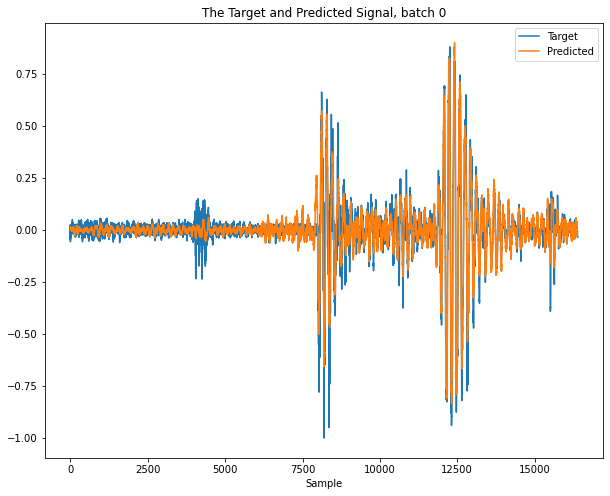

In [13]:
#Test on training set:
Xnoise=(X_train+torch.randn(X_train.size()).to(device)*0.05)
#Xnoise=torch.cat((torch.zeros(1,1,100), Xnoise),dim=-1)
predictions=model(Xnoise.cpu()) # Make Predictions based on the obtained weights, on training set
predictions=predictions.detach()
predictions=np.array(predictions)
Y=np.array(Y.cpu()) #target
print(Y.shape)
#print("Y=",Y)
print("predictions.shape=", predictions.shape)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#Plot target signal and output of autoencoder:
plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(Y[b,0,:])
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()

Xnoise=Xnoise.detach()
Xnoise=np.array(Xnoise.cpu())
xnoise=Xnoise[:,0,:]
#xnoise=np.transpose(xnoise)
#xnoise=np.clip(xnoise, -1.0,1.0)
    
xrek=predictions[:,0,:]  #remove unnecessary dimension for playback
#xrek=np.transpose(xrek)
#xrek=np.clip(xrek, -1.0,1.0)

In [14]:
torch.randn(X_train.size()).device

device(type='cpu')

In [15]:
import IPython.display as ipd
display(ipd.Audio(xnoise, rate=samplerate));

In [16]:
import IPython.display as ipd
display(ipd.Audio(xrek, rate=samplerate));

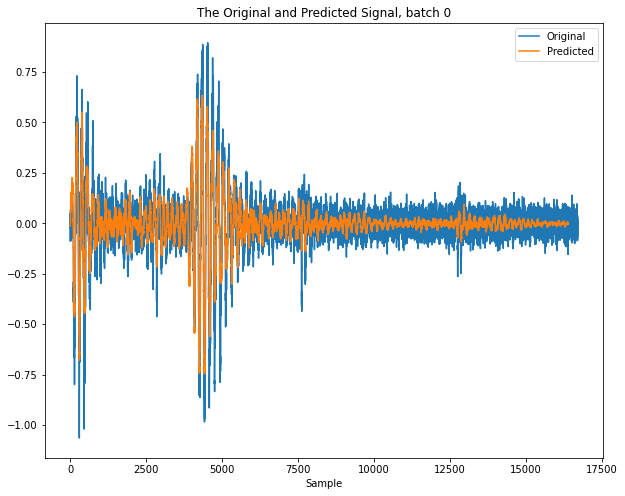

In [18]:
#Test on Verification set:
X_test_shifted_100 = nn.ConstantPad1d(100, 0)(X_test)
x=X_test_shifted_100.cpu()+torch.from_numpy((np.random.normal(scale=0.04, size=X_test_shifted_100.shape))).float()
predictions=model(x) # Make Predictions based on the obtained weights, on verification set
predictions=predictions.detach()
predictions=np.array(predictions)

plt.figure(figsize=(10,8))
for b in range(batch):
    plt.plot(np.array(x[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Original','Predicted'))
    plt.title('The Original and Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.show()
xrek=predictions[:,0,:]

In [ ]:
display(ipd.Audio(x[:,0,:], rate=samplerate))

In [ ]:
display(ipd.Audio(xrek, rate=samplerate))